In [6]:
# imports
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from surprise import AlgoBase
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [7]:
# constants and initialization
item_threshold = 1 # 1 means no filtering
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'bid'
top_fraction = 0.2
user_events_file = 'dataset/explicit/BX-Book-Explicit-5Rate-Map.csv'
low_user_file = 'groups/users/inactive_users.txt'
medium_user_file = 'groups/users/medium_users.txt'
high_user_file = 'groups/users/active_users.txt'

In [8]:
# read user events
df_events = pd.read_csv(user_events_file, sep=',', encoding='ISO-8859–1')
print('No. of user events: ' + str(len(df_events)))

No. of user events: 88552


In [9]:
df_events.head()

,uid,bid,rating
0,0,0,8
1,0,1,10
2,0,2,10
3,0,3,10
4,0,4,10


In [10]:
# get user distribution
user_dist = df_events['uid'].value_counts()
num_users = len(user_dist)
print('No. users: ' + str(num_users))
print('Mean books per user: ' + str(user_dist.mean()))
print('Min books per user: ' + str(user_dist.min()))
print('Max books per user: ' + str(user_dist.max()))

No. users: 6358
Mean books per user: 13.927650204466813
Min books per user: 5
Max books per user: 153


In [11]:
# get item distribution
item_dist = df_events['bid'].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 6921


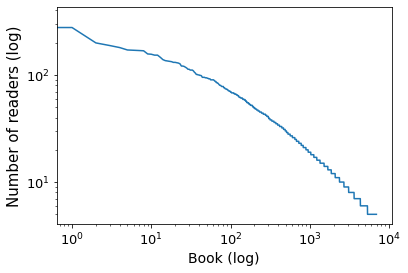

In [14]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('Book (log)', fontsize='14')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Number of readers (log)', fontsize='15')
plt.xscale('log')
plt.yscale('log')
plt.savefig('plots/book_long_tail_log.pdf', dpi=300, bbox_inches='tight')

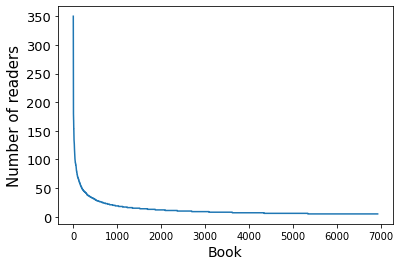

In [21]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('Book', fontsize='14')
plt.xticks(fontsize='10')
plt.yticks(fontsize='13')
plt.ylabel('Number of readers', fontsize='15')
plt.savefig('plots/book_long_tail_normal.pdf', dpi=300, bbox_inches='tight')

In [22]:
# get top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 1384


In [23]:
# read users
low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')

no_users = len(low_users) + len(medium_users) + len(high_users)

print('No. of users: ' + str(no_users))
print('No. of inactive users: ' + str(len(low_users)))
print('No. of medium users: ' + str(len(medium_users)))
print('No. of active users: ' + str(len(high_users)))

No. of users: 6358
No. of inactive users: 4282
No. of medium users: 1713
No. of active users: 363


In [24]:
# get pop fractions
predict_col = 'bid'
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0
for u, df in df_events.groupby('uid'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 4282
Med count (for check): 1713
High count (for check): 363


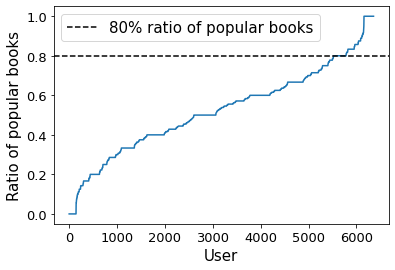

In [28]:
plt.figure()
plt.plot(sorted(pop_fraq))
plt.xlabel('User', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Ratio of popular books', fontsize='15')
plt.yticks(fontsize='13')
plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular books')
plt.legend(fontsize='15')
plt.savefig('plots/user_book_ratio.pdf', dpi=300, bbox_inches='tight')

R-value: 0.9228233272832902


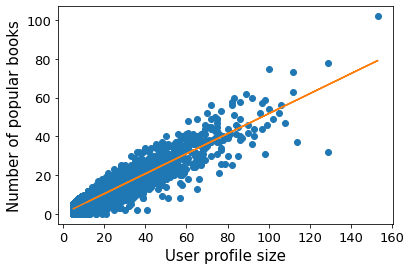

In [27]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_count)
print('R-value: ' + str(r_value))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_count, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Number of popular books', fontsize='15')
plt.yticks(fontsize='13')
plt.savefig('plots/corr_user_pop.pdf', dpi=300, bbox_inches='tight')

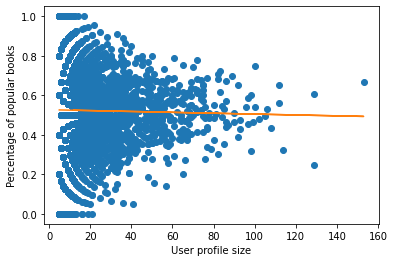

In [29]:
# we can remore it and do not use it
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_fraq)
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_fraq, 'o', user_hist, line)
plt.xlabel('User profile size')
plt.ylabel('Percentage of popular books')
plt.savefig('plots/corr_user_ratio.pdf', dpi=300, bbox_inches='tight')

R-value: -0.0335752222262517
SpearmanrResult(correlation=0.06291508367304682, pvalue=5.149636716688308e-07)


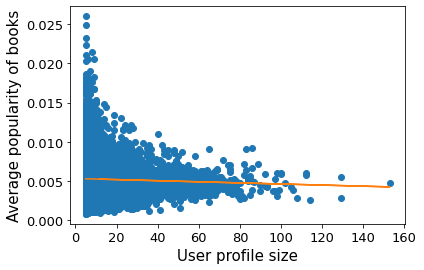

In [31]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print(stats.spearmanr(user_hist, pop_item_fraq))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_item_fraq, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='15')
plt.ylabel('Average popularity of books', fontsize='15')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.savefig('plots/corr_user_avg.pdf', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Average user profile size')

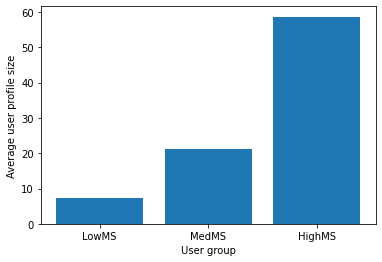

In [33]:
# plot currently not used
plt.figure()
plt.bar(np.arange(3), [low_profile_size, medium_profile_size, high_profile_size])
plt.xticks(np.arange(3), ['LowMS', 'MedMS', 'HighMS'])
plt.xlabel('User group')
plt.ylabel('Average user profile size')
# plt.savefig('data/ECIR/group_size.png', dpi=300, bbox_inches='tight')

In [34]:
print('Average LowMS profile size: ' + str(low_profile_size))
print('Average MedMS profile size: ' + str(medium_profile_size))
print('Average HighMS profile size: ' + str(high_profile_size))

Average LowMS profile size: 7.258290518449323
Average MedMS profile size: 21.115586690017512
Average HighMS profile size: 58.680440771349865


In [35]:
df_events

,uid,bid,rating
0,0,0,8
1,0,1,10
2,0,2,10
3,0,3,10
4,0,4,10
...,...,...,...
88547,6357,6837,7
88548,6357,1628,6
88549,6357,4464,8
88550,6357,5236,10
